reference: [COVID-19 Screening From Audio | Part 2](https://www.kaggle.com/code/nasrulhakim86/covid-19-screening-from-audio-part-2/notebook)

In [1]:
# utilities
import os
import sys
from tqdm import tqdm
import random

# data manipulation
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

# scipy
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
from scipy.signal import cwt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window

In [2]:
# pycaret
from pycaret.classification import *

In [3]:
# Set seed for reproducibility
seed_value= 32 
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# set variables
ROOT = 'F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/'
class_names = ['healthy','COVID-19','symptomatic']
audio_length = 22050

# load coughvid meta
data_raw = pd.read_csv(ROOT+'metadata_compiled.csv', header=0, index_col=0)
data_raw.head(3)

,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,48.9,2.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,healthy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,NaN,NaN,46.0,female,False,False,healthy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_raw.status.value_counts()

healthy        15476
symptomatic     3873
COVID-19        1315
Name: status, dtype: int64

In [ ]:
data_raw.groupby()["uuid"].count()

In [9]:
#split by physicians
physician_01, physician_02, physician_03, physician_04 = split_by_physicians(data_raw)
# combine into one dataframe
df = pd.concat([physician_01,physician_02,physician_03,physician_04]).reset_index(drop=True)  
# drop null status
df = df[df.status.notna()]
# drop cough_detected < 0.8
df = df[df.cough_detected >= 0.8 ]
# # select good and ok quality
# df = df[df.quality == 'good']
# shuffle
df = df.sample(frac=1).reset_index(drop=True) 
df = df[['uuid', 'status','cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'severity']]
df.groupby("status")["uuid"].count()

status
COVID-19    304
healthy     864
Name: uuid, dtype: int64

# 筛选优质的数据
首先取出专家标注的部分，这些才是真正用来做监督学习的。

然后
1. 去除没有status词条的行
2. 去除cough_detected小于0.8的行
3. 去除quality不是good的行
4. 仅保留专家标注的列，不再需要用户自己上报的列。

In [5]:
def split_by_physicians(df):
    column_names = ['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude', 
                    'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status', 
                    'quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 
                    'congestion', 'nothing', 'diagnosis', 'severity' ]
    physician_01 = df.iloc[:, 0:21]
    physician_01 = physician_01[physician_01.quality_1.notna()].reset_index(drop=True)
    physician_01.columns = column_names

    physician_02 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 21:31]], axis=1)
    physician_02 = physician_02[physician_02.quality_2.notna()].reset_index(drop=True)
    physician_02.columns = column_names

    physician_03 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 31:41]], axis=1)
    physician_03 = physician_03[physician_03.quality_3.notna()].reset_index(drop=True)
    physician_03.columns = column_names

    physician_04 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 41:51]], axis=1)
    physician_04 = physician_04[physician_04.quality_4.notna()].reset_index(drop=True)
    physician_04.columns = column_names
    return physician_01, physician_02, physician_03, physician_04
    
def process_csv(df):
    #split by physicians
    physician_01, physician_02, physician_03, physician_04 = split_by_physicians(df)
    # combine into one dataframe
    df = pd.concat([physician_01,physician_02,physician_03,physician_04]).reset_index(drop=True)  
    # drop null status
    df = df[df.status.notna()]
    # drop cough_detected < 0.8
    df = df[df.cough_detected >= 0.8 ]
    # select good and ok quality
    df = df[df.quality == 'good']
    # shuffle
    df = df.sample(frac=1).reset_index(drop=True) 
    df = df[['uuid', 'status','cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'severity']]
    return df

processed_df = process_csv(data_raw)
processed_df.head(3)

,uuid,status,cough_type,dyspnea,wheezing,stridor,choking,congestion,severity
0,de543d13-541c-4ad7-bb3c-c5c302de3aaf,healthy,wet,False,False,False,False,False,mild
1,0733f882-d7fd-4dc5-a1b0-8aeec64fc112,healthy,dry,False,False,False,False,False,pseudocough
2,eaae5d4e-ca16-468f-a1d9-3567a396b6da,healthy,dry,False,False,False,False,False,mild


In [6]:
processed_df.groupby("status")["uuid"].count()

status
COVID-19    152
healthy     568
Name: uuid, dtype: int64

In [7]:
processed_df.to_csv("./datasets/waveinfo_fewtoml.csv", sep=',')

# 

In [ ]:
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    #Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power                
    cough_mask = np.array([False]*len(x))
    
    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

In [ ]:
def extract_features(audio_data, sample_rate):

    features = []
    stft = np.abs(librosa.stft(audio_data))

    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc) # 40 = 40

    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features.extend(chroma) # 12 = 52

    mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel) # 128 = 180

    fmin_val = 0.5 * sample_rate * 2**(-6)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, fmin=fmin_val).T,axis=0)
    features.extend(contrast) # 7 = 187

    return np.array(features)


def load_features(df):
    all_data, all_fname = [], []
    for idx in tqdm(range(len(df))):
        fname = df.uuid.iloc[idx]
        for ext in ["webm", "wav", "ogg"]:
            path = ROOT+fname+'.'+ext
            if os.path.exists(path):
                break

        # load sound sample
        audio, sample_rate = librosa.load(path, mono=True)

        # Segment each audio into individual coughs using a hysteresis comparator on the signal power
        cough_segments, cough_mask = segment_cough(audio, sample_rate, min_cough_len=0.1, cough_padding=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)

        # For each segment, resize to the same length(11025)
        if len(cough_segments) > 0 :
            i = 0
            for audio in cough_segments:
                i+=1
                if len(audio) > 8000:
                    if len(audio) < audio_length:
                        audio_pad = librosa.util.pad_center(data=audio, size=audio_length)
                    else:
                        audio_pad = audio[:audio_length]  

                feature = extract_features(audio_pad, sample_rate)
                #print(len(feature))
                all_data.append(feature)
                all_fname.append(fname)
    
    return np.array(all_fname), np.array(all_data)

In [11]:
# This may take some time, so go watch some Korean dramas first.
uuid, X = load_features(processed_df)
print(uuid.shape)
print(X.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 720/720 [01:34<00:00,  7.64it/s]

(2850,)
(2850, 187)


In [8]:
# Store each features in different dataframe so you can choose to train all features or individual
X_mfcc = X[:, 0:40]
X_chroma = X[:, 40:52]
X_mel = X[:, 52:180]
X_contrast = X[:, 180:]

# mfcc only
uuid_df = pd.DataFrame({'uuid':uuid})
mfcc_df = pd.DataFrame(X_mfcc)
mfcc_df.columns=["mfcc"+str(i) for i in range(1, X_mfcc.shape[1]+1)]
all_mfcc_df = pd.concat([uuid_df, mfcc_df], axis=1)

# mel spectogram only
mel_df = pd.DataFrame(X_mel)
mel_df.columns=["mel"+str(i) for i in range(1, X_mel.shape[1]+1)]
all_mel_df = pd.concat([uuid_df, mel_df], axis=1)

# chroma only
chroma_df = pd.DataFrame(X_chroma)
chroma_df.columns=["chr"+str(i) for i in range(1, X_chroma.shape[1]+1)]
all_chroma_df = pd.concat([uuid_df, chroma_df], axis=1)

# contrast only
contrast_df = pd.DataFrame(X_contrast)
contrast_df.columns=["con"+str(i) for i in range(1, X_contrast.shape[1]+1)]
all_contrast_df = pd.concat([uuid_df, contrast_df], axis=1)

# all features
all_df = pd.concat([uuid_df, mfcc_df, mel_df, chroma_df, contrast_df ], axis=1)
all_df.head(3)

,uuid,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,chr10,chr11,chr12,con1,con2,con3,con4,con5,con6,con7
0,de543d13-541c-4ad7-bb3c-c5c302de3aaf,-100.570122,157.646088,-74.284904,32.992874,-7.845389,32.258888,-49.240417,9.329998,-22.528826,...,0.708594,0.692863,0.693907,17.283553,12.114343,13.585133,14.510602,16.621338,22.389913,60.343438
1,de543d13-541c-4ad7-bb3c-c5c302de3aaf,-93.907051,141.507263,-78.352165,27.417095,-7.683110,23.618828,-28.253380,-4.680555,-12.984801,...,0.719950,0.665743,0.610657,16.545310,14.023463,15.658795,17.105249,16.526091,20.232598,57.368623
2,de543d13-541c-4ad7-bb3c-c5c302de3aaf,-426.615723,64.765846,-23.962391,19.713762,-0.683824,12.066751,-13.358768,-2.419485,-1.221074,...,0.354148,0.318717,0.287694,10.209530,9.346039,9.544501,10.475563,11.797174,11.865173,22.496284


In [9]:
# Instead of predicting the status (healthy/covid/symptomatic), we train a model to to identify the cough type (dry/wet)

# Select what you would like to predict ('status', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'severity')
label_df = processed_df[['uuid', 'cough_type']].reset_index(drop=True)

# merge features and label to train
dataset = pd.merge(all_df, label_df, on='uuid')

# remove null columns
dataset = dataset[dataset.cough_type != 'unknown']
dataset.head(3)

,uuid,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,chr11,chr12,con1,con2,con3,con4,con5,con6,con7,cough_type
0,de543d13-541c-4ad7-bb3c-c5c302de3aaf,-100.570122,157.646088,-74.284904,32.992874,-7.845389,32.258888,-49.240417,9.329998,-22.528826,...,0.692863,0.693907,17.283553,12.114343,13.585133,14.510602,16.621338,22.389913,60.343438,wet
1,de543d13-541c-4ad7-bb3c-c5c302de3aaf,-100.570122,157.646088,-74.284904,32.992874,-7.845389,32.258888,-49.240417,9.329998,-22.528826,...,0.692863,0.693907,17.283553,12.114343,13.585133,14.510602,16.621338,22.389913,60.343438,wet
2,de543d13-541c-4ad7-bb3c-c5c302de3aaf,-100.570122,157.646088,-74.284904,32.992874,-7.845389,32.258888,-49.240417,9.329998,-22.528826,...,0.692863,0.693907,17.283553,12.114343,13.585133,14.510602,16.621338,22.389913,60.343438,wet


In [10]:
dataset.cough_type.value_counts()

dry    2477
wet     789
Name: cough_type, dtype: int64

In [14]:
# Fix imbalance
# print(dataset.groupby('cough_type').count())
dataset = dataset.groupby('cough_type').sample(n=788)

In [16]:
exp_clf102 = setup(
    data = dataset, 
    target = 'cough_type',
    normalize = True, 
    transformation = True, 
    # silent = True,
    ignore_features=['uuid']
)

,Description,Value
0,Session id,1418
1,Target,cough_type
2,Target type,Binary
3,Target mapping,"dry: 0, wet: 1"
4,Original data shape,"(1576, 189)"
5,Transformed data shape,"(1576, 188)"
6,Transformed train set shape,"(1103, 188)"
7,Transformed test set shape,"(473, 188)"
8,Ignore features,1
9,Numeric features,187


In [17]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7408,0.8301,0.7408,0.7437,0.7399,0.4815,0.4844,0.3230
qda,Quadratic Discriminant Analysis,0.7217,0.8200,0.7217,0.7604,0.7112,0.4431,0.4800,0.0520
rf,Random Forest Classifier,0.7154,0.8061,0.7154,0.7183,0.7145,0.4306,0.4336,0.1050
et,Extra Trees Classifier,0.7099,0.8173,0.7099,0.7136,0.7088,0.4199,0.4235,0.0730
gbc,Gradient Boosting Classifier,0.7009,0.7872,0.7009,0.7024,0.7003,0.4018,0.4032,0.5240
dt,Decision Tree Classifier,0.6882,0.7144,0.6882,0.6894,0.6877,0.3763,0.3776,0.0610
knn,K Neighbors Classifier,0.6827,0.7498,0.6827,0.6911,0.6787,0.3656,0.3737,0.2310
ada,Ada Boost Classifier,0.6664,0.7188,0.6664,0.6680,0.6655,0.3329,0.3344,0.1440
lr,Logistic Regression,0.6600,0.7097,0.6600,0.6606,0.6597,0.3200,0.3206,0.2720
ridge,Ridge Classifier,0.6501,0.0000,0.6501,0.6508,0.6496,0.3001,0.3008,0.0520


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1418, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [20]:
xgboost = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6036,0.6929,0.6036,0.6036,0.6036,0.2071,0.2071
1,0.7928,0.8760,0.7928,0.7929,0.7928,0.5855,0.5856
2,0.7477,0.8656,0.7477,0.7527,0.7463,0.4948,0.5000
3,0.7909,0.8560,0.7909,0.7957,0.7901,0.5818,0.5866
4,0.7455,0.8003,0.7455,0.7455,0.7455,0.4909,0.4909
5,0.7364,0.8233,0.7364,0.7371,0.7362,0.4727,0.4734
6,0.7909,0.8926,0.7909,0.7910,0.7909,0.5818,0.5819
7,0.7909,0.8506,0.7909,0.7933,0.7905,0.5818,0.5842
8,0.7091,0.8417,0.7091,0.7236,0.7043,0.4182,0.4324


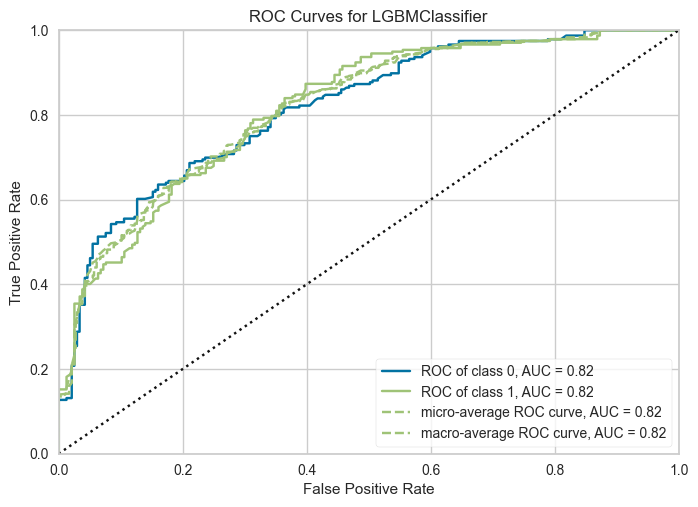

In [21]:
plot_model(xgboost)

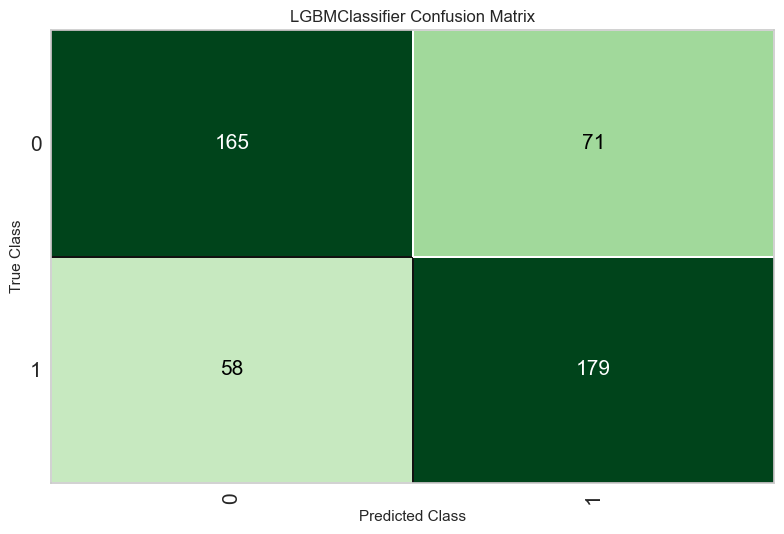

In [22]:
plot_model(xgboost, plot = 'confusion_matrix')

# End